In [17]:
# import libraties
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

# check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# created date
print("Created date: 2023-07-01 21:18:20")

# modified date
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Modified date: {now}")

PyTorch version: 1.12.1+cu102
Device: cuda
Created date: 2023-07-01 21:18:20
Modified date: 2023-07-04 13:56:04


#### Dataset

In [18]:
# load training dataset into a single batch to compute mean and stddev
transform = transforms.Compose([transforms.ToTensor()])
trainset = MNIST(root="../../data/MNIST/", 
                            download= True,
                            train=True, 
                            transform= transform)
trainloader = DataLoader(trainset, batch_size=len(trainset),shuffle=True)
data = next(iter(trainloader))
mean = data[0].mean()
stddev = data[0].std()


In [19]:
# download data
# transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=stddev)])

# train set
mnist_train = MNIST(root="../../data/MNIST/", 
                            download= True,
                            train=True, 
                            transform= transform)
# test set
mnist_test = MNIST(root="../../data/MNIST/", 
                                  download= True,
                                  train=False,
                                  transform= transform)

# training set
train_data = mnist_train.train_data
train_labels = mnist_train.train_labels

# testing set
test_data = mnist_test.test_data
test_labels = mnist_test.test_labels

In [34]:
# check train set
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of train labels: {train_labels.shape}")

# check test set
print(f"Shape of test data: {test_data.shape}")
print(f"Shape of test labels: {test_labels.shape}")

Shape of train data: torch.Size([60000, 28, 28])
Shape of train labels: torch.Size([60000])
Shape of test data: torch.Size([10000, 28, 28])
Shape of test labels: torch.Size([10000])


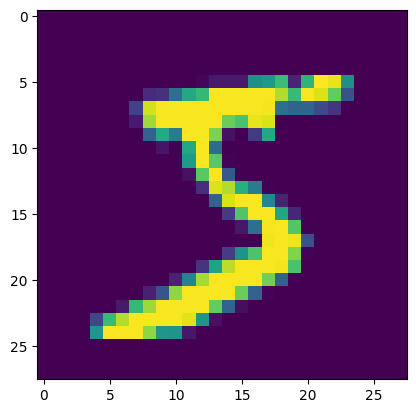

In [35]:
# visualize one sample
plt.imshow(train_data[0])

In [36]:
# check classes
class_names = mnist_train.classes
class_names, len(class_names)

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 10)

In [37]:
# check max, min of train data, test data
train_data.min(), train_data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [24]:
# check max, min of test data
test_data.min(), test_data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

#### Modeling

In [38]:
class MNISTNeuronNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=256, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=32, out_features=10)
        )

    def forward(self, x):
        return self.layers(x)

In [39]:
# set seed
torch.manual_seed(42)

# create an instance of the model
mnist_model = MNISTNeuronNetwork()

# init weights
for module in mnist_model.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        nn.init.constant_(module.bias, 0.0)

# loss_fn
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=mnist_model.parameters(), lr=0.001)

# copy model to device
mnist_model.to(device)

# batch size
batch_size = 16

# data loader
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# epochs
epochs = 50

for epoch in range(epochs):

    # accumulated train
    accumulated_train_batches = 0
    accumulated_train_loss = 0.0
    accumulated_train_acc = 0.0

    ### TRAINING
    for input, target in train_loader:

        # copy data to device
        input = input.to(device)
        target = target.to(device)
 
        # train mode
        mnist_model.train()

        # forward pass
        y_logits = mnist_model(input).squeeze()

        # calculate loss
        loss = loss_fn(y_logits, target)

        # calculate acc
        acc = torch.eq(target, torch.argmax(torch.softmax(y_logits, axis=1), axis= 1)).sum().item()

        # accumulated losses
        accumulated_train_loss += loss

        # accumulated acc
        accumulated_train_acc += acc

        # batches
        accumulated_train_batches += 1

        # zero gradients
        optimizer.zero_grad()

        # backward propagation
        loss.backward()

        # update parameters
        optimizer.step()
    
    train_loss = accumulated_train_loss / accumulated_train_batches
    train_acc = accumulated_train_acc / (accumulated_train_batches * batch_size)

    # accumulated test
    accumulated_test_batches = 0
    accumulated_test_loss = 0.0
    accumulated_test_acc = 0.0

    # test mode
    mnist_model.eval()
    with torch.inference_mode():

        ### TESTING
        for input, target in test_loader:

            # copy data to device
            input = input.to(device)
            target = target.to(device)

        
            # forward pass
            y_logits = mnist_model(input).squeeze()

            # calculate loss
            loss = loss_fn(y_logits, target)

            # calculate acc
            acc = torch.eq(target, torch.argmax(torch.softmax(y_logits, axis=1), axis= 1)).sum().item()
          
            # accumulated losses
            accumulated_test_loss += loss

            # accumulated acc
            accumulated_test_acc += acc

            # batches
            accumulated_test_batches += 1
        
        test_loss = accumulated_test_loss / accumulated_test_batches
        test_acc = accumulated_test_acc / (accumulated_test_batches * batch_size)

        print(f"Epoch: {epoch + 1}/{epochs} | Train loss: {train_loss: 0.5f} | Train acc: {test_loss: 0.2f} | Test loss: {test_loss: 0.5f} | Test acc: {test_acc: 0.2f}")


Epoch: 1/50 | Train loss:  0.34239 | Train acc:  0.14 | Test loss:  0.14084 | Test acc:  0.96
Epoch: 2/50 | Train loss:  0.18759 | Train acc:  0.11 | Test loss:  0.10960 | Test acc:  0.97
Epoch: 3/50 | Train loss:  0.15408 | Train acc:  0.10 | Test loss:  0.10055 | Test acc:  0.97
Epoch: 4/50 | Train loss:  0.13116 | Train acc:  0.09 | Test loss:  0.09207 | Test acc:  0.97
Epoch: 5/50 | Train loss:  0.11436 | Train acc:  0.09 | Test loss:  0.08625 | Test acc:  0.98
Epoch: 6/50 | Train loss:  0.10683 | Train acc:  0.09 | Test loss:  0.08789 | Test acc:  0.98
Epoch: 7/50 | Train loss:  0.10049 | Train acc:  0.10 | Test loss:  0.09737 | Test acc:  0.97
Epoch: 8/50 | Train loss:  0.08856 | Train acc:  0.09 | Test loss:  0.09215 | Test acc:  0.98
Epoch: 9/50 | Train loss:  0.08453 | Train acc:  0.09 | Test loss:  0.08531 | Test acc:  0.98
Epoch: 10/50 | Train loss:  0.08134 | Train acc:  0.09 | Test loss:  0.09252 | Test acc:  0.98
Epoch: 11/50 | Train loss:  0.07861 | Train acc:  0.09 | Te

In [40]:
# evaluation
# eval mode
mnist_model.eval()
with torch.inference_mode():
    y_pred_logits = mnist_model(test_data.type(torch.float32).to(device)).squeeze()
    y_pred_probalities = torch.softmax(y_pred_logits, dim=1)
    y_pred = torch.argmax(y_pred_probalities, dim=1)
    y_pred_cpu = y_pred.cpu()

y_pred_cpu[:5], test_labels[:5]

(tensor([7, 2, 1, 0, 4]), tensor([7, 2, 1, 0, 4]))

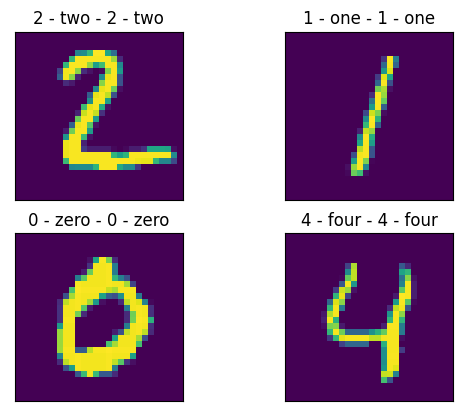

In [41]:
# visualization
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(test_data[i])
    plt.title(class_names[test_labels[i]] + " - " + class_names[y_pred_cpu[i]])
    plt.xticks([])
    plt.yticks([])

In [57]:
# torchmetrics
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

torchmetrics_accuracy(y_pred, test_labels.to(device))

tensor(0.9588, device='cuda:0')